### Imports

In [0]:
import numpy as np
import pandas as pd
import six
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold

from skimage.transform import resize

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, concatenate, UpSampling2D, SpatialDropout2D 
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import initializers, regularizers, constraints, optimizers
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.regularizers import l2
from keras.layers.merge import add

import tensorflow as tf

from tqdm import tqdm_notebook

import gc

### Mount google drive to google colab to pull tgs kaggle csv files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Parameters

In [0]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
      return img
    else:
      return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
      return img
    else:
      return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [1]:
model_name = f'Unet_2Resnet_300epochs'
save_model = model_name + '.model'
submission_csv = model_name + '.csv'

print(save_model)
print(submission_csv)

Unet_2Resnet_300epochs.model
Unet_2Resnet_300epochs.csv


### Import train and depth csv from google drive

In [5]:
from google.colab import files
files.upload()

Saving train.csv to train.csv


{'train.csv': b'id,rle_mask\n575d24d81d,\na266a2a9df,5051 5151\n75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96 712 97 812 98 913 98 1015 97 1116 97 1216 98 1316 99 1416 8786\n34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 49 762 47 864 46 966 45 1068 44 1171 42 1273 41 1376 39 1478 38 1581 36 1683 35 1785 34 1888 32 1990 31 2092 30 2195 28 2297 27 2399 26 2501 25 2602 25 2704 24 2806 23 2907 23 3009 22 3110 22 3212 21 3313 21 3414 21 3516 20 3617 20 3718 20 3819 20 3921 19 4022 19 4123 19 4225 18 4326 18 4428 17 4529 17 4631 16 4733 15 4834 15 4936 14 5038 13 5140 12 5242 11 5344 8\n4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716 2 1817 2 1918 2 2018 3 2119 3 2220 3 2321 3 2422 3 2523 3 2624 3 2725 3 2826 3 2927 3 3028 3 3129 3 3230 3 3331 3 3432 3 3533 3 3636 1 3737 1 3838 1 3938 2 4039 2 4140 2 4240 3 4341 3 4442 3 4542 4 4643 4 4744 4 4844 5 4945 5 5046 5 5146 6 5247 6 5347 7 5448 7 5549 7 5649 8 5750 8 5851 8 5952 8 6053 8 6154 8 6255 8 6355 9 6456 9 6

In [7]:
from google.colab import files
files.upload()

Saving depths.csv to depths.csv


{'depths.csv': b'id,z\n4ac19fb269,306\n1825fadf99,157\nf59821d067,305\n5b435fad9d,503\ne340e7bfca,783\n2ffea0c397,429\n6cf284fb9e,600\nd0244d6c38,51\ncffbfab33b,755\ne82421363e,68\n9090f8f97b,253\n778a92f420,476\n57e394bc67,765\n1efe1909ed,143\n8d89d465fc,529\n211fc910da,336\nb12a5a2b61,475\n28948eeb9c,306\n28f6f52c8f,317\n211eb21702,188\n4ee5d2c629,421\nfe9e558605,535\nac1ea6faa4,635\n380ff30e30,892\n99d7f0c538,500\nc3589905df,236\n16e308dbc3,313\n48bb098115,649\n07ac7e530f,638\n6c4568e51c,364\n2f3eff4192,262\n9b09626522,722\n691dc0bc42,453\ne875c9a960,576\n25d24d4554,587\n64baad8029,791\n39a05bf91f,749\n2787bfe603,832\na849a4e373,480\n4ed12ec89a,526\ne7ee2c6dce,669\n3480629331,423\n2c45b152f1,312\n6b2f7ba83d,518\n4ad8a63538,82\nde091953f9,694\n04e7e791e2,391\n2d3c0a68f9,623\nfa92bed2b1,810\neabe9337a9,540\nc385af3da9,270\n6dfaae4996,424\n730eee262c,362\n81d37cb5fd,321\nefbfde4930,649\na9a9fb1747,369\n1263576548,398\nff9b7d0d2e,332\nf4784e4f1f,172\n290e9d9748,784\n368767c9fd,261\n8b09

### Load training testing ids and depths

In [0]:
train_df = pd.read_csv("/content/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/content/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

### Read in Images and Masks

- Load images and masks into data frame
- Neural Network expects values between 0 and 1
- Divide image values by 255 to normalize the input. 
- Each image in the grayscale has a value of between 0 and 255. 
- Dividing by 255 results in each value to be between 0 and 1.

In [209]:
train_df["images"] = [np.array(load_img("/content/drive/My Drive/tgs-salt-identification-challenge/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [210]:
train_df["masks"] = [np.array(load_img("/content/drive/My Drive/tgs-salt-identification-challenge/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


### Calculate salt coverage and salt coverage classes

- Dividing the number of salt pixels by the image size. This gives the fraction of salt pixes in the mask
- Creating salt coverage classes ranging from 0.0 (no salt) to 1.0 (only salt)

In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

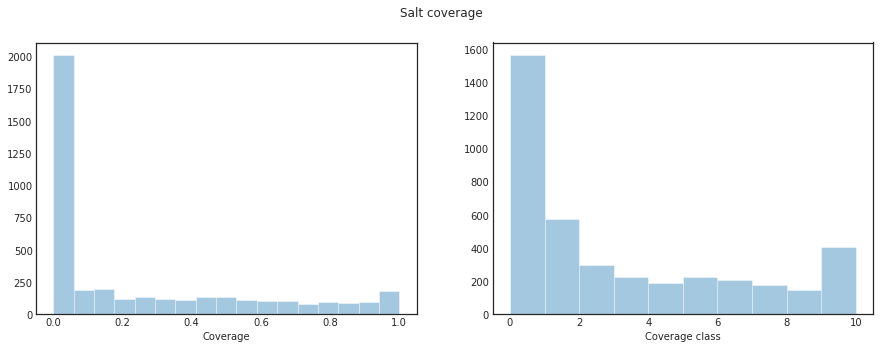

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

### Create train split stratified by salt coverage

> Instead of randomly splitting the data use the salt coverage to avoid any unwanted bias in the split. This helps maintain a better distribution of the salty and non salty images between the splits

In [0]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, X_train, X_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.25, stratify=train_df.coverage_class, random_state= 713)

### U-Net

In [0]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [0]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5
    
    # Encoder path            
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # Decoder Path 
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4]) # Skip Connection
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3]) # Skip Connection     
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2]) # Skip Connection
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1]) # Skip Connection
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

### Define the Intersection of Union Vector 

In [0]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

### Augment

- Flip each image from left to right
- Tried other augmentation, but best scores came from only using np.fliplr()
- Creates more images for model to be trained on
- Model can learn from seeing salt pixels in different part of images

In [219]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(X_train.shape)
print(y_valid.shape)

(6000, 101, 101, 1)
(1000, 101, 101, 1)


### Training

In [22]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)
model = Model(input_layer, output_layer)
c = optimizers.adam(lr = 0.01)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[iou_metric])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [23]:
early_stopping = EarlyStopping(monitor='iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model,monitor='iou_metric',
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=300,
                    batch_size=32,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)



Train on 6000 samples, validate on 1000 samples
Epoch 1/300
6000/6000 [==============================] - 43s 7ms/step - loss: 0.4415 - iou_metric: 0.1359 - val_loss: 0.4377 - val_iou_metric: 0.3677

Epoch 00001: iou_metric improved from -inf to 0.13588, saving model to Unet_resnet_version_7.model
Epoch 2/300
6000/6000 [==============================] - 25s 4ms/step - loss: 0.3036 - iou_metric: 0.3308 - val_loss: 0.3541 - val_iou_metric: 0.4731

Epoch 00002: iou_metric improved from 0.13588 to 0.33085, saving model to Unet_resnet_version_7.model
Epoch 3/300
6000/6000 [==============================] - 25s 4ms/step - loss: 0.2712 - iou_metric: 0.4169 - val_loss: 0.3594 - val_iou_metric: 0.5480

Epoch 00003: iou_metric improved from 0.33085 to 0.41690, saving model to Unet_resnet_version_7.model
Epoch 4/300
6000/6000 [==============================] - 25s 4ms/step - loss: 0.2524 - iou_metric: 0.4460 - val_loss: 0.2305 - val_iou_metric: 0.5821

Epoch 00004: iou_metric improved from 0.416

In [0]:
# Plot loss and iou metric

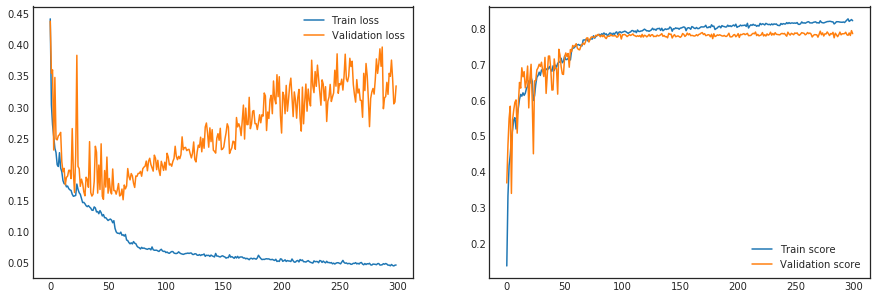

In [25]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_iou_metric"], label="Validation score")
ax_score.legend()

### Sanity Check show original, true mask, predicted mask, predicted mask binary

In [0]:
# load the best model
model.load_weights(save_model)

In [28]:
# Evaluate on validation set
model.evaluate(X_valid, y_valid, verbose=1)

1000/1000 [==============================] - 1s 1ms/step


[0.37514113129675386, 0.7801]

In [29]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1000/1000 [==============================] - 1s 1ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
# Plotting original seismic image, true mask, predicted mask, and predicted mask binary 

def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('True Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted');

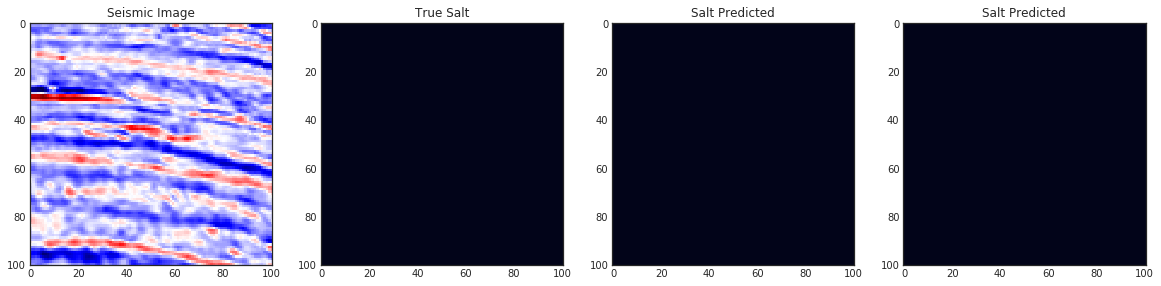

In [230]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Load model looking at iou_metric

In [0]:
model = load_model(save_model,custom_objects={'iou_metric': iou_metric})

### Predict model on the x_test

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [0]:
preds_valid = predict_result(model,X_valid,img_size_target)

### Score model and choose threshold based on the validation data

In [0]:
#Score the model and do a threshold optimization by the best IoU.
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

     # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [194]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.



[0.1323 0.1323 0.1323 0.1323 0.1323 0.1323 0.1323 0.1323 0.1323 0.1323
 0.1323 0.1323 0.1323 0.1323 0.1323 0.1355 0.638  0.7072 0.7352 0.7536
 0.7653 0.772  0.7756 0.7827 0.7915 0.7907 0.7905 0.7874 0.7813 0.7716
 0.765 ]


In [ ]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

### Convert decoded image to rle mask. (Reduces speed)

### From kaggle 

Submission File
In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The pixels are one-indexed
and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. It also checks that no two predicted masks for the same image are overlapping.

The file should contain a header and have the following format. Each row in your submission represents a single predicted salt segmentation for the given image.

In [0]:
# Used to convert the decoded image to rle mask
# im: numpy array, 1 - mask, 0 - background
# Returns run length as string formated

def rle_encode(im):
    
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [197]:
# for some reason it would not recognize my X_test when scoring on the prediction so looked on stack overflow
# saw that to use delete everything but the X_test and use gs.collect()

del X_train, X_valid, y_train, y_valid, preds_valid
gc.collect()

174309

### Convert test images to numpy arrays. Very slow, a lot of images (18,000). Predict on test images

In [199]:
x_test = np.array([(np.array(load_img("/content/drive/My Drive/tgs-salt-identification-challenge/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
preds_test = predict_result(model,x_test,img_size_target)

### Set up for kaggle submission using rle encoder

In [ ]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_csv)